In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
import shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 62.5 MB 4.4 MB/s eta 0:00:01


In [8]:
path = '/home/mandal.n/VML/Project/Data/image_sets'
classes = [folder for folder in os.listdir(path) if folder != '.ipynb_checkpoints']
#classes = os.listdir(path)
classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

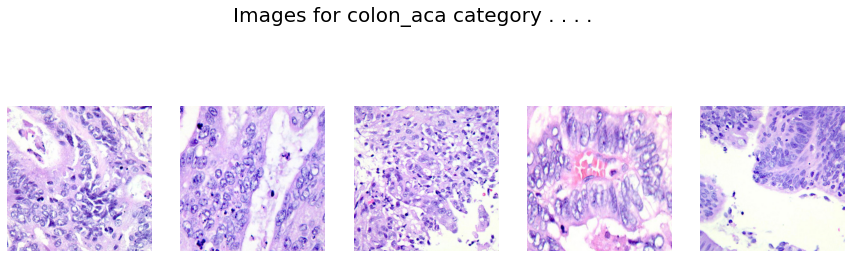

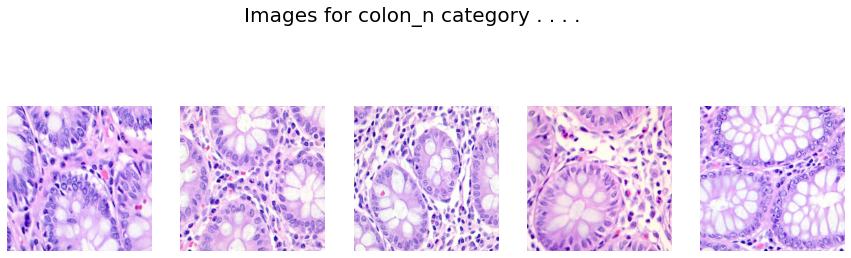

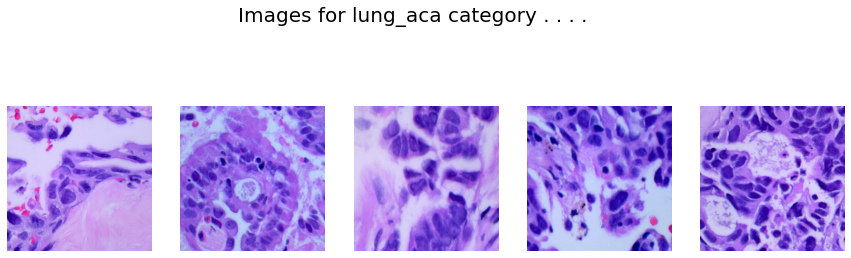

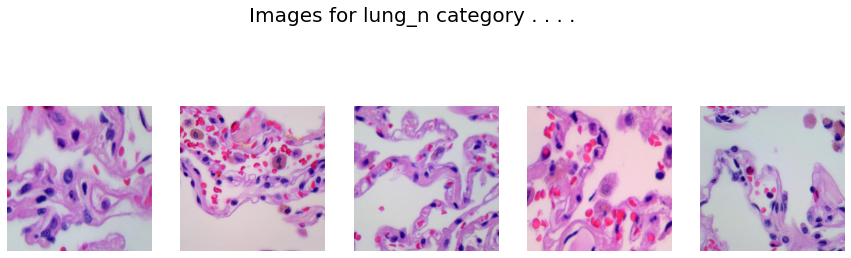

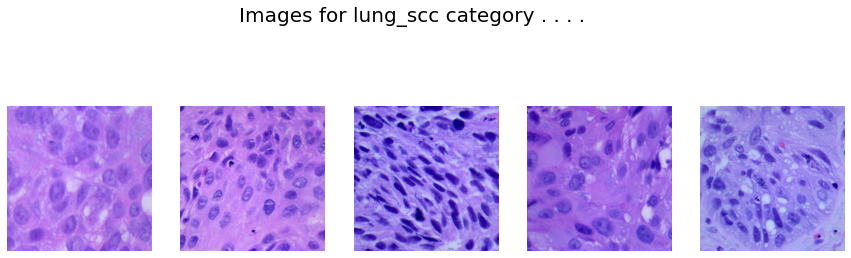

In [9]:
path = '/home/mandal.n/VML/Project/Data/image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 5, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(5):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()

In [20]:
unwanted_dir = '/home/mandal.n/VML/Project/Data/image_sets/.ipynb_checkpoints'
if os.path.exists(unwanted_dir):
    shutil.rmtree(unwanted_dir)
dirpath='/home/mandal.n/VML/Project/Data/image_sets'
#dirpath=[folder for folder in os.listdir(path) if folder != '.ipynb_checkpoints']
IMG_SIZE=180
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 5

In [21]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    dirpath,
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 8481 files belonging to 5 classes.


In [22]:
classes_name=dataset.class_names
classes_name

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

In [23]:
for batch_img,batch_label in dataset.take(1):
    print(batch_img.shape)
    print(batch_label.numpy())

(32, 180, 180, 3)
[0 4 4 1 4 3 3 2 0 4 2 2 0 0 3 1 3 4 4 3 4 4 4 0 2 1 3 2 3 2 3 4]


In [24]:
def split_train_val_test(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
   assert(train_split+val_split+test_split)==1


   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   val_size=int(val_split*len(dataset))
   test_size=int(test_split*len(dataset))


   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size).take(test_size)


   return train_ds,val_ds,test_ds

In [25]:
train,val,test=split_train_val_test(dataset)

In [26]:
print(len(train))
print(len(test))
print(len(val))

212
26
26


In [27]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

In [29]:
cnn_model=tf.keras.models.Sequential([
    resize_scaling,
    layers.Conv2D(32, kernel_size = (3,3),padding='same',activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(N_CLASSES,activation='softmax')

])

In [30]:
cnn_model.build(input_shape=INPUT_SHAPE)

In [31]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 180, 180, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 90, 90, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 90, 90, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 45, 45, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 43, 43, 64)         

In [32]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = 'logs')
#checkpoint =tf.keras.callbacks.ModelCheckpoint("colon.keras",monitor="val_loss",save_best_only=True,mode="auto",verbose=1)
checkpoint = ModelCheckpoint(filepath="colon.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)

In [33]:
cnn_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [34]:
#history=cnn_model.fit(train_ds,validation_data=val_ds,epochs=40,batch_size=BATCH_SIZE,verbose=1,
             #callbacks=[tensorboard,checkpoint,early_stopping,reduce_lr])
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[tensorboard, early_stopping, reduce_lr]
)

Epoch 1/40
212/212 [==============================] - 32s 126ms/step - loss: 0.5135 - accuracy: 0.7739 - val_loss: 1.5559 - val_accuracy: 0.4279 - lr: 0.0010
Epoch 2/40
212/212 [==============================] - 24s 113ms/step - loss: 0.3243 - accuracy: 0.8688 - val_loss: 3.8530 - val_accuracy: 0.2139 - lr: 0.0010
Epoch 3/40
212/212 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.8845
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
212/212 [==============================] - 25s 116ms/step - loss: 0.2865 - accuracy: 0.8845 - val_loss: 3.2907 - val_accuracy: 0.5168 - lr: 0.0010
Epoch 4/40
212/212 [==============================] - 25s 116ms/step - loss: 0.1709 - accuracy: 0.9348 - val_loss: 0.4871 - val_accuracy: 0.7692 - lr: 3.0000e-04
Epoch 5/40
212/212 [==============================] - 24s 112ms/step - loss: 0.1443 - accuracy: 0.9449 - val_loss: 1.0252 - val_accuracy: 0.7163 - lr: 3.0000e-04
Epoch 6/40
212/212 [=====================

In [35]:
cnn_model.evaluate(test_ds)

26/26 [==============================] - 6s 35ms/step - loss: 0.0667 - accuracy: 0.9784


[0.06673810631036758, 0.9783653616905212]

In [36]:
train_score = cnn_model.evaluate(train_ds, verbose= 1)
valid_score = cnn_model.evaluate(val_ds, verbose= 1)
test_score =cnn_model.evaluate(test_ds, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

26/26 [==============================] - 1s 33ms/step - loss: 0.0667 - accuracy: 0.9784
Train Loss:  0.04986383393406868
Train Accuracy:  0.985784113407135
--------------------
Validation Loss:  0.08360664546489716
Validation Accuracy:  0.9723557829856873
--------------------
Test Loss:  0.06673811376094818
Test Accuracy:  0.9783653616905212


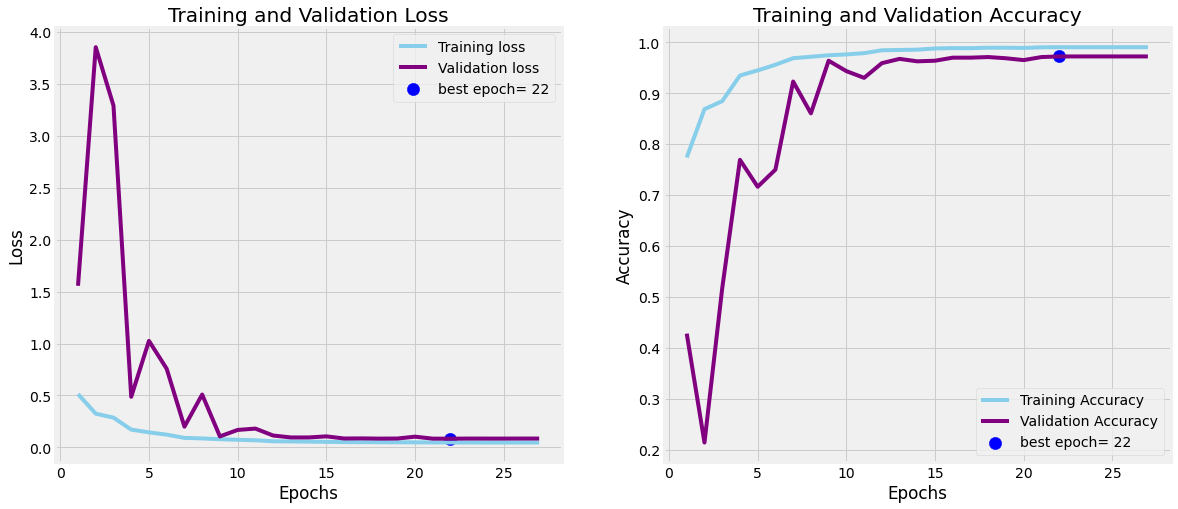

In [37]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'skyblue', label= 'Training loss')
plt.plot(Epochs, val_loss, 'purple', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'skyblue', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'purple', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

1/1 [==============================] - 0s 74ms/step
              precision    recall  f1-score   support

   colon_aca       0.99      0.97      0.98       169
     colon_n       0.97      0.99      0.98       165
    lung_aca       0.98      0.96      0.97       168
      lung_n       1.00      1.00      1.00       158
    lung_scc       0.96      0.98      0.97       172

    accuracy                           0.98       832
   macro avg       0.98      0.98      0.98       832
weighted avg       0.98      0.98      0.98       832



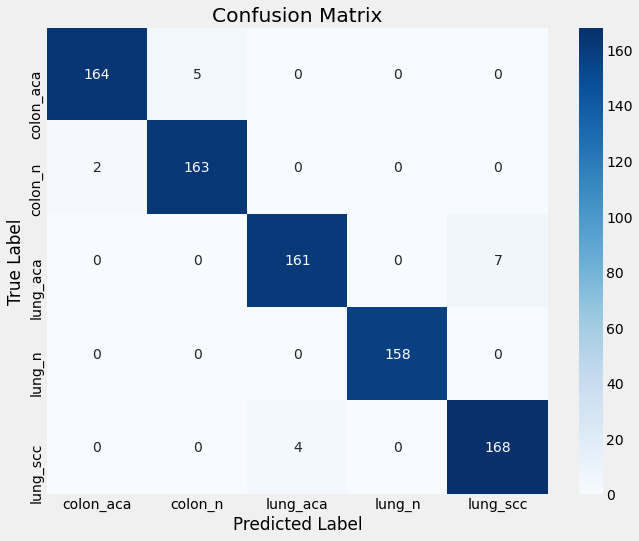

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def display_conf_matrix():
    all_true_labels = []
    all_predicted_labels = []

    # Assuming 'dataset.class_names' contains the names of the classes
    classes_name = dataset.class_names

    for image_batch, label_batch in test_ds:
        # Make predictions on the batch
        predictions = cnn_model.predict(image_batch)

        # Convert predictions to class indices
        predicted_labels = np.argmax(predictions, axis=1)

        # No need to convert if labels are not one-hot encoded
        true_labels = label_batch

        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

    # Convert lists to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    # Print classification report
    print(classification_report(all_true_labels, all_predicted_labels, target_names=classes_name))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes_name, yticklabels=classes_name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Now call the function
display_conf_matrix()

In [39]:
def get_predicitions():
    all_true_labels = []
    all_predicted_labels = []
    all_images=[]

    classes_name=dataset.class_names
    #get all the predictions and true labels
    for image_batch, label_batch in test_ds:
            # Make predictions on the batch
            predictions = cnn_model.predict(image_batch)

            # Convert predictions to class indices
            predicted_labels = np.argmax(predictions, axis=1)

            #append matrix of images
            all_images.extend(image_batch)
            true_labels = label_batch

            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

            print(len(all_true_labels))
    #plot the predictions
    index=0
    plt.figure(figsize=(20, 20))
    plt.suptitle('Prediction of Colon Cancer!')

    for i in range(30,61):
        if index<15:
            ax=plt.subplot(5,3,index+1)
            color = 'green' if all_true_labels[i] == all_predicted_labels[i] else 'red'
            plt.title(f'true_class:{classes_name[all_true_labels[i]]}\npredicted_class:{classes_name[all_predicted_labels[i]]}',color=color)
            plt.imshow(np.array(all_images[i]).astype('uint8'))
            plt.axis('off')
            index+=1
        else:
            index=0

1/1 [==============================] - 0s 78ms/step
32
1/1 [==============================] - 0s 71ms/step
64
1/1 [==============================] - 0s 67ms/step
96
1/1 [==============================] - 0s 74ms/step
128
1/1 [==============================] - 0s 70ms/step
160
1/1 [==============================] - 0s 72ms/step
192
1/1 [==============================] - 0s 89ms/step
224
1/1 [==============================] - 0s 69ms/step
256
1/1 [==============================] - 0s 68ms/step
288
1/1 [==============================] - 0s 66ms/step
320
1/1 [==============================] - 0s 64ms/step
352
1/1 [==============================] - 0s 75ms/step
384
1/1 [==============================] - 0s 69ms/step
416
1/1 [==============================] - 0s 65ms/step
448
1/1 [==============================] - 0s 74ms/step
480
1/1 [==============================] - 0s 72ms/step
512
1/1 [==============================] - 0s 72ms/step
544
1/1 [==============================] - 0s 65ms/step

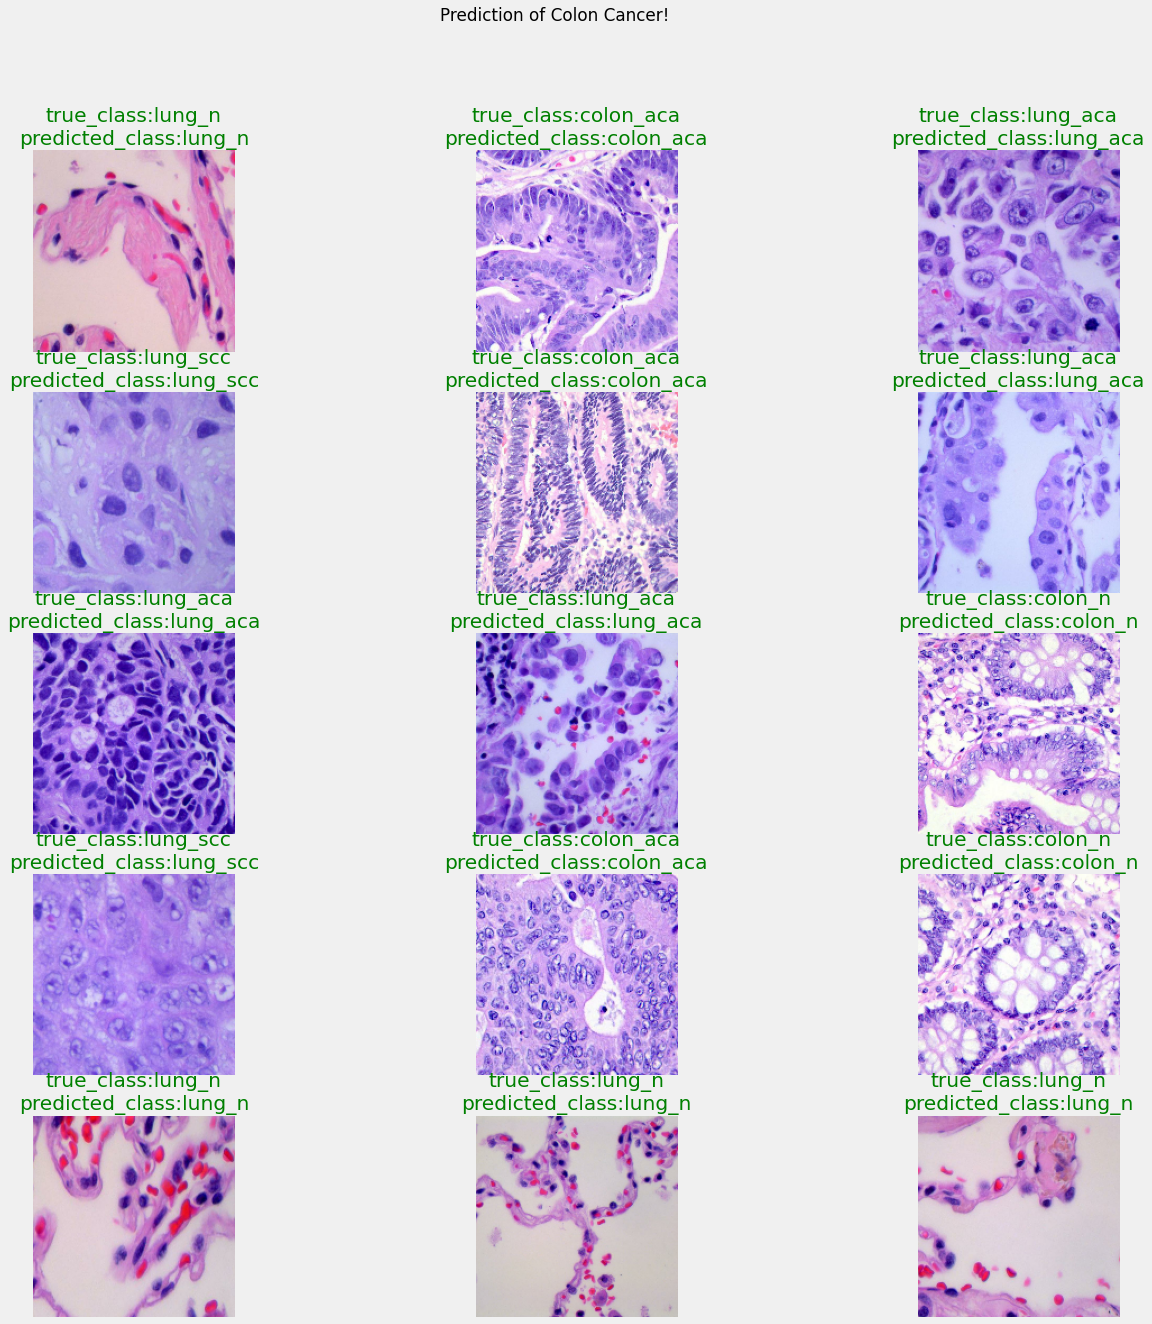

In [40]:
get_predicitions()

In [43]:
cnn_model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model/assets


INFO:tensorflow:Assets written to: cnn_model/assets


In [44]:
cnn_model.save('cnn_model.h5')